# Stroke Prediction

You can find the dataset in: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/discussion

## Import Libraries

In [47]:
!pip install imblearn joblib


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.impute
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib

In [2]:
%run pandas-missing-extension.ipynb

## Load Data

In [3]:
df_data = pd.read_csv('healthcare-dataset-stroke-data.csv')
df_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## Management of categorical variables

In [5]:
# Seeing which of our variables are categorical
categorical_columns = df_data.select_dtypes(include=[object, 'category']).columns
categorical_columns

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [6]:
# Compose transformation instructions of our data
categorical_transformer = make_column_transformer(
    # Tuple with the encoder and the variables to be transformed
    (OrdinalEncoder(), categorical_columns),
    # What we want to do with the variables?
    # remainder: options "drop" and "passthrough"
    remainder='passthrough'
)

In [7]:
# Store this in a new DataFrame
df_data_processing = (
    pd.DataFrame(
        categorical_transformer.fit_transform(df_data),
        columns=categorical_transformer.get_feature_names_out(),
        # This line is to keep the index of the original dataset
        index = df_data.index
    )
    .rename_columns(
        function = lambda x: x.replace('ordinalencoder__','')
    )
    .rename_columns(
        function = lambda x: x.replace('remainder__','')
    )
)
df_data_processing

,gender,ever_married,work_type,Residence_type,smoking_status,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,1.0,1.0,2.0,1.0,1.0,9046.0,67.0,0.0,1.0,228.69,36.6,1.0
1,0.0,1.0,3.0,0.0,2.0,51676.0,61.0,0.0,0.0,202.21,NaN,1.0
2,1.0,1.0,2.0,0.0,2.0,31112.0,80.0,0.0,1.0,105.92,32.5,1.0
3,0.0,1.0,2.0,1.0,3.0,60182.0,49.0,0.0,0.0,171.23,34.4,1.0
4,0.0,1.0,3.0,0.0,2.0,1665.0,79.0,1.0,0.0,174.12,24.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0.0,1.0,2.0,1.0,2.0,18234.0,80.0,1.0,0.0,83.75,NaN,0.0
5106,0.0,1.0,3.0,1.0,2.0,44873.0,81.0,0.0,0.0,125.20,40.0,0.0
5107,0.0,1.0,3.0,0.0,2.0,19723.0,35.0,0.0,0.0,82.99,30.6,0.0
5108,1.0,1.0,2.0,0.0,1.0,37544.0,51.0,0.0,0.0,166.29,25.6,0.0


## Eliminate the ID

In [8]:
df_data_processing.drop('id', axis=1, inplace=True)

In [9]:
df_data_processing

,gender,ever_married,work_type,Residence_type,smoking_status,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,1.0,1.0,2.0,1.0,1.0,67.0,0.0,1.0,228.69,36.6,1.0
1,0.0,1.0,3.0,0.0,2.0,61.0,0.0,0.0,202.21,NaN,1.0
2,1.0,1.0,2.0,0.0,2.0,80.0,0.0,1.0,105.92,32.5,1.0
3,0.0,1.0,2.0,1.0,3.0,49.0,0.0,0.0,171.23,34.4,1.0
4,0.0,1.0,3.0,0.0,2.0,79.0,1.0,0.0,174.12,24.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5105,0.0,1.0,2.0,1.0,2.0,80.0,1.0,0.0,83.75,NaN,0.0
5106,0.0,1.0,3.0,1.0,2.0,81.0,0.0,0.0,125.20,40.0,0.0
5107,0.0,1.0,3.0,0.0,2.0,35.0,0.0,0.0,82.99,30.6,0.0
5108,1.0,1.0,2.0,0.0,1.0,51.0,0.0,0.0,166.29,25.6,0.0


## Null data management

In [10]:
df_data_processing.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,gender,0,5110,0.000000
1,ever_married,0,5110,0.000000
2,work_type,0,5110,0.000000
3,Residence_type,0,5110,0.000000
4,smoking_status,0,5110,0.000000
5,age,0,5110,0.000000
6,hypertension,0,5110,0.000000
7,heart_disease,0,5110,0.000000
8,avg_glucose_level,0,5110,0.000000
9,bmi,201,5110,3.933464


### Making a prediction to fill NaN values

In [11]:
# We can fill the Nan values by the KNN algorithm
KNN_imputer = sklearn.impute.KNNImputer()

df_data_processing_knn = df_data_processing.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)

# We will need to round these values, because they are decimal in some cases
df_data_processing_knn.iloc[:,:] = KNN_imputer.fit_transform(df_data_processing.missing.sort_variables_by_missingness(ascending=True)).round()
df_data_processing_knn

,gender,ever_married,work_type,Residence_type,smoking_status,age,hypertension,heart_disease,avg_glucose_level,stroke,bmi
0,1.0,1.0,2.0,1.0,1.0,67.0,0.0,1.0,229.0,1.0,37.0
1,0.0,1.0,3.0,0.0,2.0,61.0,0.0,0.0,202.0,1.0,34.0
2,1.0,1.0,2.0,0.0,2.0,80.0,0.0,1.0,106.0,1.0,32.0
3,0.0,1.0,2.0,1.0,3.0,49.0,0.0,0.0,171.0,1.0,34.0
4,0.0,1.0,3.0,0.0,2.0,79.0,1.0,0.0,174.0,1.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...
5105,0.0,1.0,2.0,1.0,2.0,80.0,1.0,0.0,84.0,0.0,27.0
5106,0.0,1.0,3.0,1.0,2.0,81.0,0.0,0.0,125.0,0.0,40.0
5107,0.0,1.0,3.0,0.0,2.0,35.0,0.0,0.0,83.0,0.0,31.0
5108,1.0,1.0,2.0,0.0,1.0,51.0,0.0,0.0,166.0,0.0,26.0


<AxesSubplot:xlabel='avg_glucose_level', ylabel='bmi'>

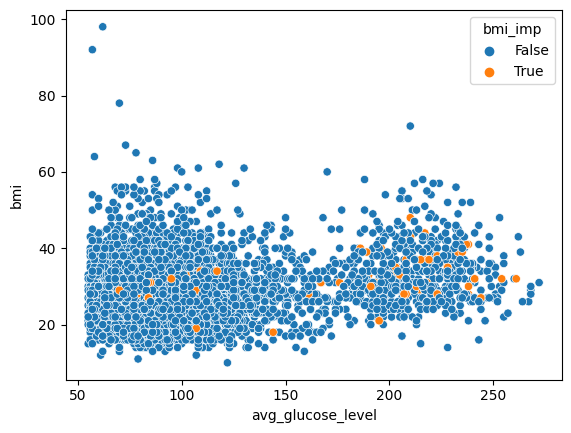

In [12]:
df_data_plot = (
    pd.concat(
        [
            df_data_processing_knn,
            df_data_processing.missing.create_shadow_matrix(True, False, suffix='_imp', only_missing=True)
        ],
        axis=1
    )
)

sns.scatterplot(data=df_data_plot, x='avg_glucose_level', y='bmi', hue='bmi_imp')

## Correlation Analysis

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'work_type'),
  Text(1, 0, 'gender'),
  Text(2, 0, 'Residence_type'),
  Text(3, 0, 'smoking_status'),
  Text(4, 0, 'bmi'),
  Text(5, 0, 'ever_married'),
  Text(6, 0, 'hypertension'),
  Text(7, 0, 'avg_glucose_level'),
  Text(8, 0, 'heart_disease'),
  Text(9, 0, 'age')])

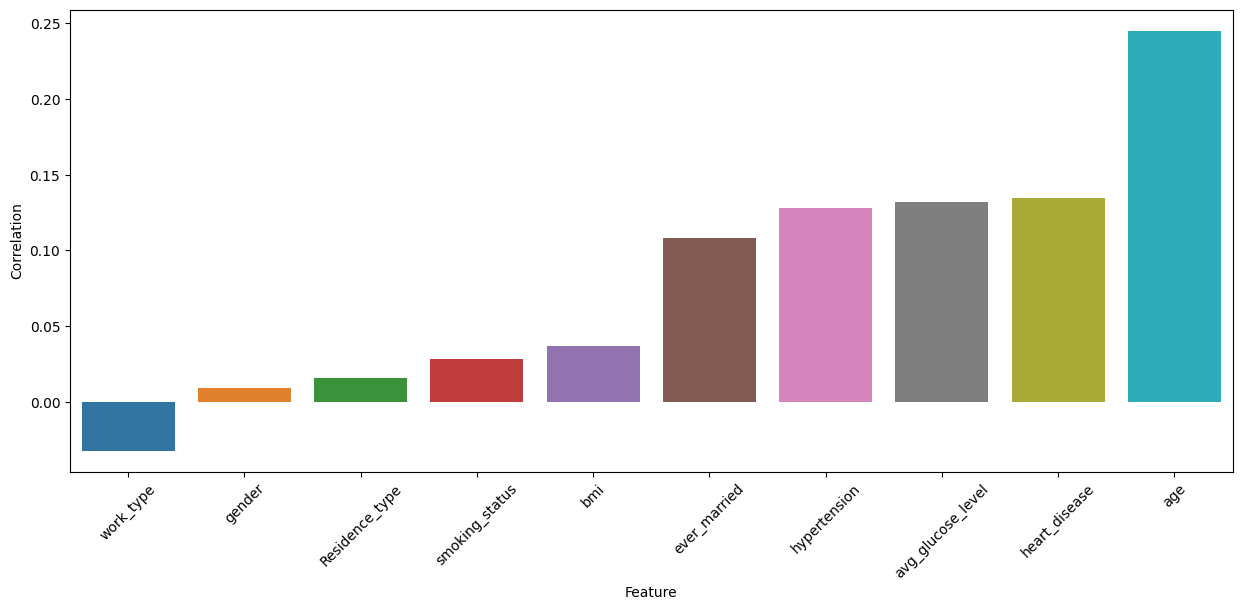

In [13]:
# With Seaborn
plt.figure(figsize=(15,6))
data_corr = pd.DataFrame(df_data_processing_knn.corr()['stroke'].sort_values(ascending=True)[:-1]).reset_index()
sns.barplot(data=data_corr, x="index", y="stroke")
plt.ylabel("Correlation")
plt.xlabel("Feature")
plt.xticks(rotation=45)

## Data Scalability

In [14]:
scaler = MinMaxScaler()
df_data_processing_scaled = scaler.fit_transform(df_data_processing_knn)

In [15]:
# How to convert this Tensor to a DataFrame
df_data_processing_scaled = pd.DataFrame(df_data_processing_scaled,
             columns=df_data_processing_knn.columns)

In [16]:
df_data_processing_scaled

,gender,ever_married,work_type,Residence_type,smoking_status,age,hypertension,heart_disease,avg_glucose_level,stroke,bmi
0,0.5,1.0,0.50,1.0,0.333333,0.817073,0.0,1.0,0.801843,1.0,0.306818
1,0.0,1.0,0.75,0.0,0.666667,0.743902,0.0,0.0,0.677419,1.0,0.272727
2,0.5,1.0,0.50,0.0,0.666667,0.975610,0.0,1.0,0.235023,1.0,0.250000
3,0.0,1.0,0.50,1.0,1.000000,0.597561,0.0,0.0,0.534562,1.0,0.272727
4,0.0,1.0,0.75,0.0,0.666667,0.963415,1.0,0.0,0.548387,1.0,0.159091
...,...,...,...,...,...,...,...,...,...,...,...
5105,0.0,1.0,0.50,1.0,0.666667,0.975610,1.0,0.0,0.133641,0.0,0.193182
5106,0.0,1.0,0.75,1.0,0.666667,0.987805,0.0,0.0,0.322581,0.0,0.340909
5107,0.0,1.0,0.75,0.0,0.666667,0.426829,0.0,0.0,0.129032,0.0,0.238636
5108,0.5,1.0,0.50,0.0,0.333333,0.621951,0.0,0.0,0.511521,0.0,0.181818


## Balancing the data

### Split the output and inputs

In [18]:
X = df_data_processing_scaled.drop("stroke", axis=1)
y = df_data_processing_scaled['stroke']

In [22]:
np.unique(y.values, return_counts=True)

(array([0., 1.]), array([4861,  249], dtype=int64))

#### To avoid loss many data we will apply an oversampling

In [30]:
sm = SMOTE(random_state=42)
X_over, y_over = sm.fit_resample(X,y)

In [31]:
np.unique(y_over.values, return_counts=True)

(array([0., 1.]), array([4861, 4861], dtype=int64))

In [33]:
X_over.head()

,gender,ever_married,work_type,Residence_type,smoking_status,age,hypertension,heart_disease,avg_glucose_level,bmi
0,0.5,1.0,0.50,1.0,0.333333,0.817073,0.0,1.0,0.801843,0.306818
1,0.0,1.0,0.75,0.0,0.666667,0.743902,0.0,0.0,0.677419,0.272727
2,0.5,1.0,0.50,0.0,0.666667,0.975610,0.0,1.0,0.235023,0.250000
3,0.0,1.0,0.50,1.0,1.000000,0.597561,0.0,0.0,0.534562,0.272727
4,0.0,1.0,0.75,0.0,0.666667,0.963415,1.0,0.0,0.548387,0.159091


In [34]:
y_over.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: stroke, dtype: float64

## Training the model

### Spliting training and test data

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.25, random_state=42, shuffle=True)

### Applying the LogisticRegressionModel with GridSearchCV

In [40]:
# Parameter grid
parameters = {
    'solver': ['newton-cg', 'saga', 'lbfgs', 'liblinear', 'sag'],
    'multi_class': ['ovr', 'multinomial'],
    'random_state': [42],
    'n_jobs':[1],
    'max_iter':[1000],
    'C': [1, 0.5, 0.1]
}

clf = GridSearchCV(
    LogisticRegression(),
    param_grid=parameters,
    scoring='accuracy',
    cv=10,
    verbose=2
)

clf.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] END C=1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=ovr, n_jobs=1, r

[CV] END C=1, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=liblinear; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=liblinear; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=liblinear; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=liblinear; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=liblinear; total time=   0.0s
[CV] END C=1, max_iter=1000, multi_class=multinomial, n_jobs=1, rand

[CV] END C=0.5, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=0.5, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=0.5, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=0.5, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=0.5, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=0.5, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=0.5, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=0.5, max_iter=1000, multi_class=multinomial, n_jobs=1, random_state=42, solver=newton-cg; total time=   0.0s
[CV] END C=0.5, max_iter=1000, multi_cla

[CV] END C=0.1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=liblinear; total time=   0.0s
[CV] END C=0.1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=liblinear; total time=   0.0s
[CV] END C=0.1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=liblinear; total time=   0.0s
[CV] END C=0.1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=sag; total time=   0.0s
[CV] END C=0.1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=sag; total time=   0.0s
[CV] END C=0.1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=sag; total time=   0.0s
[CV] END C=0.1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=sag; total time=   0.0s
[CV] END C=0.1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=sag; total time=   0.0s
[CV] END C=0.1, max_iter=1000, multi_class=ovr, n_jobs=1, random_state=42, solver=sag; total time=   0.0s
[CV] END C=0.1, max_iter=100

C:\Users\TUF GAMER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\TUF GAMER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\TUF GAMER\anaconda3\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\TUF GAMER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1218, in fit
    multi_class = _check_multi_class(self.multi

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [1, 0.5, 0.1], 'max_iter': [1000],
                         'multi_class': ['ovr', 'multinomial'], 'n_jobs': [1],
                         'random_state': [42],
                         'solver': ['newton-cg', 'saga', 'lbfgs', 'liblinear',
                                    'sag']},
             scoring='accuracy', verbose=2)

In [41]:
# Printing the best accuracy and hyperparameters in the model
print("Best hyperparameters: ", clf.best_params_)
print("Best accuracy: ", clf.best_score_)

Best hyperparameters:  {'C': 0.1, 'max_iter': 1000, 'multi_class': 'ovr', 'n_jobs': 1, 'random_state': 42, 'solver': 'newton-cg'}
Best accuracy:  0.7865856775090666


### RandomForestClassifier

In [45]:
# Parameter grid
parameters = {
    'max_depth': list(range(10, 15)), 
    'max_features': list(range(0,14)),
    'random_state': [42],
    'n_jobs':[1],
}

clf_2 = GridSearchCV(
    RandomForestClassifier(),
    param_grid=parameters,
    scoring='accuracy',
    cv=10,
    verbose=2
)

clf_2.fit(X_train, y_train)

Fitting 10 folds for each of 70 candidates, totalling 700 fits
[CV] END max_depth=10, max_features=0, n_jobs=1, random_state=42; total time=   0.0s
[CV] END max_depth=10, max_features=0, n_jobs=1, random_state=42; total time=   0.0s
[CV] END max_depth=10, max_features=0, n_jobs=1, random_state=42; total time=   0.0s
[CV] END max_depth=10, max_features=0, n_jobs=1, random_state=42; total time=   0.0s
[CV] END max_depth=10, max_features=0, n_jobs=1, random_state=42; total time=   0.0s
[CV] END max_depth=10, max_features=0, n_jobs=1, random_state=42; total time=   0.0s
[CV] END max_depth=10, max_features=0, n_jobs=1, random_state=42; total time=   0.0s
[CV] END max_depth=10, max_features=0, n_jobs=1, random_state=42; total time=   0.0s
[CV] END max_depth=10, max_features=0, n_jobs=1, random_state=42; total time=   0.0s
[CV] END max_depth=10, max_features=0, n_jobs=1, random_state=42; total time=   0.0s
[CV] END max_depth=10, max_features=1, n_jobs=1, random_state=42; total time=   0.4s
[C

[CV] END max_depth=10, max_features=9, n_jobs=1, random_state=42; total time=   2.1s
[CV] END max_depth=10, max_features=9, n_jobs=1, random_state=42; total time=   2.1s
[CV] END max_depth=10, max_features=9, n_jobs=1, random_state=42; total time=   2.2s
[CV] END max_depth=10, max_features=9, n_jobs=1, random_state=42; total time=   2.1s
[CV] END max_depth=10, max_features=10, n_jobs=1, random_state=42; total time=   2.3s
[CV] END max_depth=10, max_features=10, n_jobs=1, random_state=42; total time=   2.4s
[CV] END max_depth=10, max_features=10, n_jobs=1, random_state=42; total time=   2.3s
[CV] END max_depth=10, max_features=10, n_jobs=1, random_state=42; total time=   2.3s
[CV] END max_depth=10, max_features=10, n_jobs=1, random_state=42; total time=   2.4s
[CV] END max_depth=10, max_features=10, n_jobs=1, random_state=42; total time=   2.4s
[CV] END max_depth=10, max_features=10, n_jobs=1, random_state=42; total time=   2.3s
[CV] END max_depth=10, max_features=10, n_jobs=1, random_s

[CV] END max_depth=11, max_features=5, n_jobs=1, random_state=42; total time=   1.4s
[CV] END max_depth=11, max_features=5, n_jobs=1, random_state=42; total time=   1.4s
[CV] END max_depth=11, max_features=5, n_jobs=1, random_state=42; total time=   1.4s
[CV] END max_depth=11, max_features=5, n_jobs=1, random_state=42; total time=   1.4s
[CV] END max_depth=11, max_features=5, n_jobs=1, random_state=42; total time=   1.4s
[CV] END max_depth=11, max_features=5, n_jobs=1, random_state=42; total time=   1.4s
[CV] END max_depth=11, max_features=5, n_jobs=1, random_state=42; total time=   1.4s
[CV] END max_depth=11, max_features=5, n_jobs=1, random_state=42; total time=   1.4s
[CV] END max_depth=11, max_features=6, n_jobs=1, random_state=42; total time=   1.6s
[CV] END max_depth=11, max_features=6, n_jobs=1, random_state=42; total time=   1.7s
[CV] END max_depth=11, max_features=6, n_jobs=1, random_state=42; total time=   1.7s
[CV] END max_depth=11, max_features=6, n_jobs=1, random_state=42;

[CV] END max_depth=12, max_features=1, n_jobs=1, random_state=42; total time=   0.5s
[CV] END max_depth=12, max_features=1, n_jobs=1, random_state=42; total time=   0.5s
[CV] END max_depth=12, max_features=1, n_jobs=1, random_state=42; total time=   0.5s
[CV] END max_depth=12, max_features=1, n_jobs=1, random_state=42; total time=   0.5s
[CV] END max_depth=12, max_features=1, n_jobs=1, random_state=42; total time=   0.5s
[CV] END max_depth=12, max_features=1, n_jobs=1, random_state=42; total time=   0.5s
[CV] END max_depth=12, max_features=1, n_jobs=1, random_state=42; total time=   0.5s
[CV] END max_depth=12, max_features=1, n_jobs=1, random_state=42; total time=   0.5s
[CV] END max_depth=12, max_features=1, n_jobs=1, random_state=42; total time=   0.5s
[CV] END max_depth=12, max_features=1, n_jobs=1, random_state=42; total time=   0.5s
[CV] END max_depth=12, max_features=2, n_jobs=1, random_state=42; total time=   0.7s
[CV] END max_depth=12, max_features=2, n_jobs=1, random_state=42;

[CV] END max_depth=12, max_features=10, n_jobs=1, random_state=42; total time=   2.6s
[CV] END max_depth=12, max_features=10, n_jobs=1, random_state=42; total time=   2.7s
[CV] END max_depth=12, max_features=10, n_jobs=1, random_state=42; total time=   2.6s
[CV] END max_depth=12, max_features=11, n_jobs=1, random_state=42; total time=   2.6s
[CV] END max_depth=12, max_features=11, n_jobs=1, random_state=42; total time=   2.7s
[CV] END max_depth=12, max_features=11, n_jobs=1, random_state=42; total time=   2.6s
[CV] END max_depth=12, max_features=11, n_jobs=1, random_state=42; total time=   2.7s
[CV] END max_depth=12, max_features=11, n_jobs=1, random_state=42; total time=   2.6s
[CV] END max_depth=12, max_features=11, n_jobs=1, random_state=42; total time=   2.6s
[CV] END max_depth=12, max_features=11, n_jobs=1, random_state=42; total time=   2.6s
[CV] END max_depth=12, max_features=11, n_jobs=1, random_state=42; total time=   2.6s
[CV] END max_depth=12, max_features=11, n_jobs=1, rand

[CV] END max_depth=13, max_features=6, n_jobs=1, random_state=42; total time=   1.8s
[CV] END max_depth=13, max_features=6, n_jobs=1, random_state=42; total time=   1.8s
[CV] END max_depth=13, max_features=6, n_jobs=1, random_state=42; total time=   1.8s
[CV] END max_depth=13, max_features=6, n_jobs=1, random_state=42; total time=   1.8s
[CV] END max_depth=13, max_features=6, n_jobs=1, random_state=42; total time=   1.8s
[CV] END max_depth=13, max_features=6, n_jobs=1, random_state=42; total time=   1.8s
[CV] END max_depth=13, max_features=6, n_jobs=1, random_state=42; total time=   1.8s
[CV] END max_depth=13, max_features=7, n_jobs=1, random_state=42; total time=   2.1s
[CV] END max_depth=13, max_features=7, n_jobs=1, random_state=42; total time=   2.1s
[CV] END max_depth=13, max_features=7, n_jobs=1, random_state=42; total time=   2.1s
[CV] END max_depth=13, max_features=7, n_jobs=1, random_state=42; total time=   2.1s
[CV] END max_depth=13, max_features=7, n_jobs=1, random_state=42;

[CV] END max_depth=14, max_features=1, n_jobs=1, random_state=42; total time=   0.6s
[CV] END max_depth=14, max_features=2, n_jobs=1, random_state=42; total time=   0.8s
[CV] END max_depth=14, max_features=2, n_jobs=1, random_state=42; total time=   0.8s
[CV] END max_depth=14, max_features=2, n_jobs=1, random_state=42; total time=   0.8s
[CV] END max_depth=14, max_features=2, n_jobs=1, random_state=42; total time=   0.8s
[CV] END max_depth=14, max_features=2, n_jobs=1, random_state=42; total time=   0.8s
[CV] END max_depth=14, max_features=2, n_jobs=1, random_state=42; total time=   0.8s
[CV] END max_depth=14, max_features=2, n_jobs=1, random_state=42; total time=   0.8s
[CV] END max_depth=14, max_features=2, n_jobs=1, random_state=42; total time=   0.8s
[CV] END max_depth=14, max_features=2, n_jobs=1, random_state=42; total time=   0.8s
[CV] END max_depth=14, max_features=2, n_jobs=1, random_state=42; total time=   0.8s
[CV] END max_depth=14, max_features=3, n_jobs=1, random_state=42;

[CV] END max_depth=14, max_features=11, n_jobs=1, random_state=42; total time=   2.9s
[CV] END max_depth=14, max_features=11, n_jobs=1, random_state=42; total time=   2.9s
[CV] END max_depth=14, max_features=11, n_jobs=1, random_state=42; total time=   3.0s
[CV] END max_depth=14, max_features=11, n_jobs=1, random_state=42; total time=   2.9s
[CV] END max_depth=14, max_features=12, n_jobs=1, random_state=42; total time=   2.9s
[CV] END max_depth=14, max_features=12, n_jobs=1, random_state=42; total time=   3.0s
[CV] END max_depth=14, max_features=12, n_jobs=1, random_state=42; total time=   2.9s
[CV] END max_depth=14, max_features=12, n_jobs=1, random_state=42; total time=   3.3s
[CV] END max_depth=14, max_features=12, n_jobs=1, random_state=42; total time=   2.9s
[CV] END max_depth=14, max_features=12, n_jobs=1, random_state=42; total time=   3.0s
[CV] END max_depth=14, max_features=12, n_jobs=1, random_state=42; total time=   2.9s
[CV] END max_depth=14, max_features=12, n_jobs=1, rand

C:\Users\TUF GAMER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\TUF GAMER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\TUF GAMER\anaconda3\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\TUF GAMER\anaconda3\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\TUF GAMER\anacond

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 11, 12, 13, 14],
                         'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                          12, 13],
                         'n_jobs': [1], 'random_state': [42]},
             scoring='accuracy', verbose=2)

In [46]:
# Printing the best accuracy and hyperparameters in the model
print("Best hyperparameters: ", clf_2.best_params_)
print("Best accuracy: ", clf_2.best_score_)

Best hyperparameters:  {'max_depth': 14, 'max_features': 3, 'n_jobs': 1, 'random_state': 42}
Best accuracy:  0.9369094462295884


## Predictions

In [49]:
predictions = clf_2.predict(X_test)

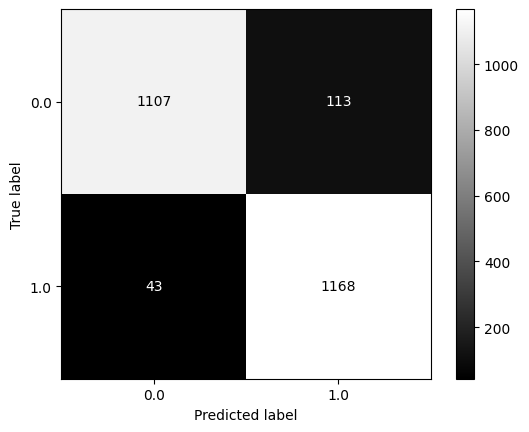

In [52]:
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot(cmap='gray')
plt.show()

## Storing the model

In [55]:
joblib.dump(clf_2, './models/random_forest_model.plk')

['./models/random_forest_model.plk']

In [56]:
joblib.dump(clf, './models/logistic_regression_model.plk')

['./models/logistic_regression_model.plk']

### Testing the model

In [57]:
input_data = (0.5,1.0,0.50,1.0,0.333333,0.817073,0.0,1.0,0.9000,0.306818)

# Chaging the  input_data to a numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the numpy array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1, -1)

In [59]:
prediction_1 = clf_2.predict(input_data_reshaped)

C:\Users\TUF GAMER\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [62]:
if(prediction_1[0] == 1):
  print("The person had a stroke")
else:
  print("The did not have a stroke")

The person had a stroke
